In [93]:
import numpy as np
#import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [94]:
import seaborn as sns

In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [96]:
import h5py

In [97]:
from uatu.scattering import *

In [98]:
from scipy.ndimage import gaussian_filter
from lenstools import GaussianNoiseGenerator, ConvergenceMap
from astropy.units import deg

In [99]:
model_path = '/home/sean/Git/uatu/networks/deep_resnet_reg_smooth_1.0_noise_0.3_07_adv2.pth'

In [100]:
#downsample_factor = 4
shape = (256, 256)
in_channels = 1
width = 2

depth = 5#[16, 32, 64, 64, 64, 64, 64]

In [101]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [102]:
model = DeepResnet(input_size = shape[0], in_channels=in_channels, n_subplanes=width, depth=depth, shuffle_layers=0).to(device)

In [103]:
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [104]:
model.eval();

In [105]:
def log_barrier(x_p, x_o, eps=0.5, lam=5e2):
    # TODO, in pytorch
    norm = (x_p - x_o).norm(p=2) + 1e-6

    assert norm < eps
    return -torch.log(eps - norm )/lam

In [106]:
def fgsm_attack(image, eps, data_grad):

    sign_data_grad = data_grad.clone()
    # clipping    
    delta = eps*image.std().detach()

    sign_data_grad[sign_data_grad>delta] = delta
    sign_data_grad[sign_data_grad<-delta] = -delta

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image.detach() - sign_data_grad.detach()

    return perturbed_image


In [107]:
def get_embedding(x, model):

    x = x.view(1, model.K, model.input_size, model.input_size)#
    x = model.init_conv(x)

    for l in model.layers:
        x = l(x)

    x = model.avgpool(x)
    #x = x.view(x.size(0), -1)
    ##x = model.fc(x)
    return x


In [108]:
def get_pred(x, model):

    return model(x) # same as getting the embedding of the final output layer


In [109]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=10*deg)
    l1, psd1D = cmap.powerSpectrum(l)

    return l1, psd1D#/psd1D[0]

In [110]:
def image_pc(image):
    #image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=10*deg)
    thresholds = np.linspace(-0.01, 0.04,  41)
    #thresholds = np.linspace(-5, 5, 200)
    nu,peaks = cmap.peakCount(thresholds, norm=False)
    return nu, peaks#/psd1D[0]

In [111]:
def compute_attacked_map(model, data, target, use_log_barrier = False, n_steps = 5, lr = 1e-3,
                         min_loss = True):#, log_eps = 1.5)
    data = data.to(device)
    perturbed_data = data.clone().to(device)
    target = target.to(device)
    for i in range(n_steps):

        perturbed_data.requires_grad_()

        with torch.enable_grad():
            output = model(perturbed_data)
            if use_log_barrier:
                lb = log_barrier(data, perturbed_data)
            else:
                lb = 0
            loss = (output-target).norm(p=1) + lb

            

        data_grad = torch.autograd.grad(loss, [perturbed_data])[0]

        # sign change is important to make it a gradient ascent if we are trying to maximize the loss on a particular ex.
        if not min_loss:
            data_grad*=-1
        perturbed_data = fgsm_attack(perturbed_data, lr, data_grad)

    return perturbed_data#, init_pred, output


In [112]:
smooth = 1#0
noise = 0.29
shape_noise = noise/np.sqrt((2.34**2)*30) #sigma_e/sqrt(A*n)
np.random.seed(0)
data_mod = lambda x: np.log10(gaussian_filter(x+np.random.randn(*x.shape)*shape_noise, smooth)+1.0) # add a normalization, hopefully sufficient
transform = torch.Tensor

In [113]:
all_test_ys = np.zeros((50,2))
with h5py.File('/home/sean/Git/uatu/data/UatuFastPMTest.hdf5', 'r') as f:
    for i in range(50):
        all_test_ys[i] = f['Box%03d'%i]['Y'][0].squeeze()

In [114]:
mean_y = all_test_ys.mean(axis=0)
fid_idx = np.argmin(np.sum((all_test_ys - mean_y)**2, axis=1) )

In [115]:
orig_cosmo_idx = 23#fid_idx
orig_map_idx = 128
target_cosmo_idx = 1#1#0
target_map_idx = 512

In [116]:
def load_data(cosmo_idx, map_idx):
    with h5py.File('/home/sean/Git/uatu/data/UatuFastPMTest.hdf5', 'r') as f:
        X = f['Box%03d'%cosmo_idx]['X'][map_idx].squeeze()
        y = f['Box%03d'%cosmo_idx]['Y'][map_idx].squeeze()
            
    return data_mod(X),y

In [117]:
X_orig, y_orig = load_data(orig_cosmo_idx, orig_map_idx)

In [118]:
y_orig

array([0.279925, 0.846988])

In [119]:
X_targ, y_targ = load_data(target_cosmo_idx, target_map_idx)

In [120]:
y_targ

array([0.353419, 1.011647])

In [121]:
#y_targ = y_orig*1.5

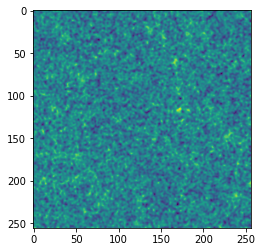

In [122]:
plt.imshow(X_orig.squeeze())

In [123]:
X_attacked = compute_attacked_map(model,\
                                  torch.Tensor(X_orig ).reshape((1, shape[0], shape[1])), \
                                #torch.Tensor(X_targ).reshape((1, shape[0], shape[1])), 
                                  torch.Tensor(y_targ),use_log_barrier=True,
                                    n_steps=500,lr = 1e-2, min_loss=True)#,\

In [124]:
X_attacked = X_attacked.to('cpu').detach().numpy().squeeze()

In [125]:
vmin, vmax = X_orig.min()*1.1, X_orig.max()*1.1

In [126]:
init_pred = model(torch.Tensor(X_orig ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
#init_targ_pred = model(torch.Tensor(X_targ ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
final_targ_pred = model(torch.Tensor(X_attacked ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()

In [127]:
y_targ

array([0.353419, 1.011647])

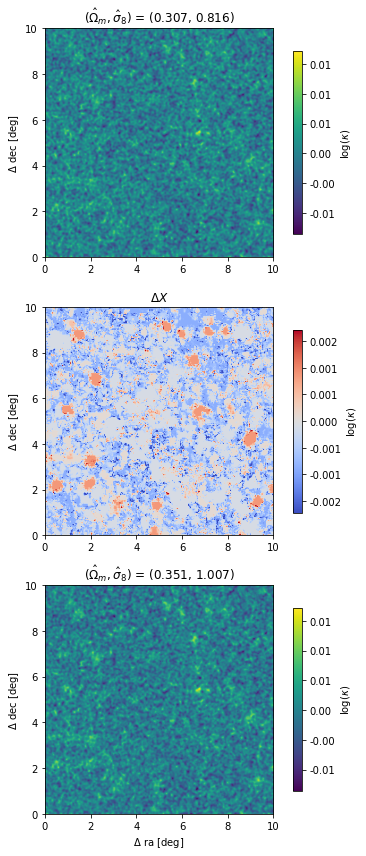

In [128]:
#fig = plt.figure(figsize = (16,4))
#fig, axes = plt.subplots(1,3,figsize=(12,6))
fig, axes = plt.subplots(3,1,figsize=(6,12))

fig.set_facecolor('w')

#plt.title('Orig Image')
im = axes[0].imshow(X_orig.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[0].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(init_pred[0], init_pred[1]) )
#plt.title('Diff Image')
fig.colorbar(im, ax=axes[0], shrink = 0.8, label = r'$\log(\kappa)$', format='%0.2f')
m = 10.0
im = axes[1].imshow((X_attacked.squeeze()-X_orig.squeeze() ), vmin = -vmax/m, vmax= vmax/m,extent=[0,10,0,10], cmap='coolwarm')
#axes[1].set_title(r'$%d \times \Delta X$'%m)
axes[1].set_title(r'$\Delta X$')
fig.colorbar(im, ax=axes[1], shrink = 0.8, label = r'$\log(\kappa)$', format='%0.3f')

#plt.title('Perturbed Image')
im = axes[2].imshow(X_attacked.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
axes[2].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(final_targ_pred[0], final_targ_pred[1]) )

#im = axes[1][1].imshow(X_targ.squeeze(), vmin = vmin, vmax= vmax,extent=[0,10,0,10])
#axes[1][1].set_title(r'($\hat{\Omega}_m, \hat{\sigma}_8$) = (%0.3f, %0.3f)'%(init_targ_pred[0], init_targ_pred[1]) )

fig.colorbar(im, ax=axes[2], shrink = 0.8, label = r'$\log(\kappa)$', format='%0.2f')
for i in range(3):
    axes[2].set_xlabel(r'$\Delta$ ra [deg]')
    axes[i].set_ylabel(r'$\Delta$ dec [deg]')
plt.tight_layout()


In [129]:
X_robust = X_attacked

In [130]:
init_pred = model(torch.Tensor(X_orig ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
#init_targ_pred = model(torch.Tensor(X_targ ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()
final_targ_pred = model(torch.Tensor(X_attacked ).reshape((1, shape[0], shape[1])).to(device)).cpu().detach().numpy().squeeze()

In [131]:
init_pred, y_orig

(array([0.3065545, 0.8162712], dtype=float32), array([0.279925, 0.846988]))

In [132]:
final_targ_pred, y_targ

(array([0.35081393, 1.0065808 ], dtype=float32), array([0.353419, 1.011647]))

In [133]:
vmin, vmax = X_orig.min()*1.1, X_orig.max()*1.1

In [134]:
vmin, vmax

(-0.013600185905235802, 0.017168679642301368)

In [135]:
def plot_ps(X_orig, X_target, X_attack):
    
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    l, attacked_ps = image_ps(X_attack.squeeze())
    _,target_ps = image_ps(X_target.squeeze())
    _,normal_ps = image_ps(X_orig.squeeze())
    _,diff_ps = image_ps((X_attack.squeeze()- X_orig.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    axes[0].plot(l,attacked_ps, label = 'Attacked' )
    axes[0].plot(l,target_ps, label = 'Target')
    axes[0].plot(l,normal_ps, label = 'Original')
    axes[0].set_ylabel('$P(l)$')
    #plt.plot(diff_ps, label = 'Diff')

    axes[0].legend(loc='best', frameon=False)
    axes[0].loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    axes[1].plot(l,attacked_ps/normal_ps, label = 'Attacked/Original')
    axes[1].plot(l,target_ps/normal_ps, label = 'Target/Original')
    axes[1].legend(loc='best')
    axes[1].loglog()
    axes[1].set_ylabel('$P(l)/P_{orig}(l)$')
    axes[1].set_xlabel(r'$l\; \mathrm{[h/Mpc]}$')
    axes[1].set_ylim([0.2, 5])
    plt.show();

In [136]:
def plot_pc(X_orig, X_target, X_attack):
    
    fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True)
    nu, attacked_pc = image_pc(X_attack.squeeze())
    #nu = (nu[:1]+nu[:-1])/2.0

    _,target_pc = image_pc(X_target.squeeze())
    _,normal_pc = image_pc(X_orig.squeeze())
    _,diff_pc = image_pc((X_attack.squeeze()- X_orig.squeeze()).squeeze())
    
    #fig = plt.figure(figsize = (8, 12))
    #plt.subplot(211)
    axes[0].plot(nu,attacked_pc, label = 'Attacked' )
    axes[0].plot(nu,target_pc, label = 'Target')
    axes[0].plot(nu,normal_pc, label = 'Original')
    axes[0].set_ylabel('Peak Counts')
    axes[0].set_yscale('log')
    #plt.plot(diff_ps, label = 'Diff')

    axes[0].legend(loc='best', frameon=False)
    #axes[0].loglog();
    #plt.subplot(212)
    #plt.title("Attacked/Normal")
    axes[1].plot(nu,attacked_pc/normal_pc, label = 'Attacked/Original')
    axes[1].plot(nu, target_pc/normal_pc, label = 'Target/Original')
    axes[1].legend(loc='best')
    #axes[1].loglog()
    axes[1].set_ylabel('$Peak Counts Ratio$')
    axes[1].set_xlabel(r'$\kappa$') # todo unites?
    axes[1].set_ylim([0.5, 2])
    plt.show();

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


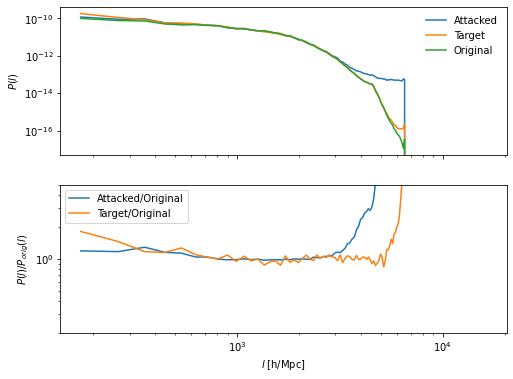

In [137]:
plot_ps(X_orig, X_targ, X_robust)

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


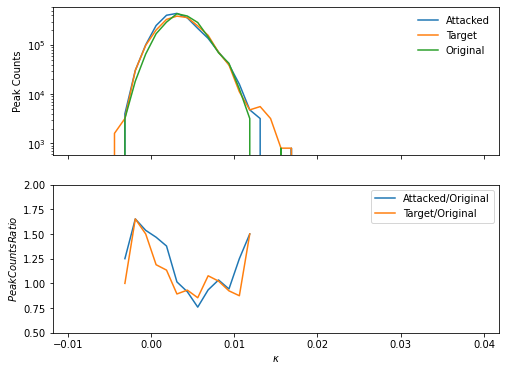

In [138]:
plot_pc(X_orig, X_targ, X_robust)